In [38]:
import os

os.environ['HDF5_DISABLE_VERSION_CHECK'] = "1"

import datetime as dt 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr

from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from eofs.xarray import Eof
from esem import rf_model
from glob import glob

from matplotlib import colors


import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from utils_rf import *

In [39]:
# path to save the net-cdf file
path_output ='outputs_ssp245_prediction_ESEm.nc'


### Initial EDA to look at variables 

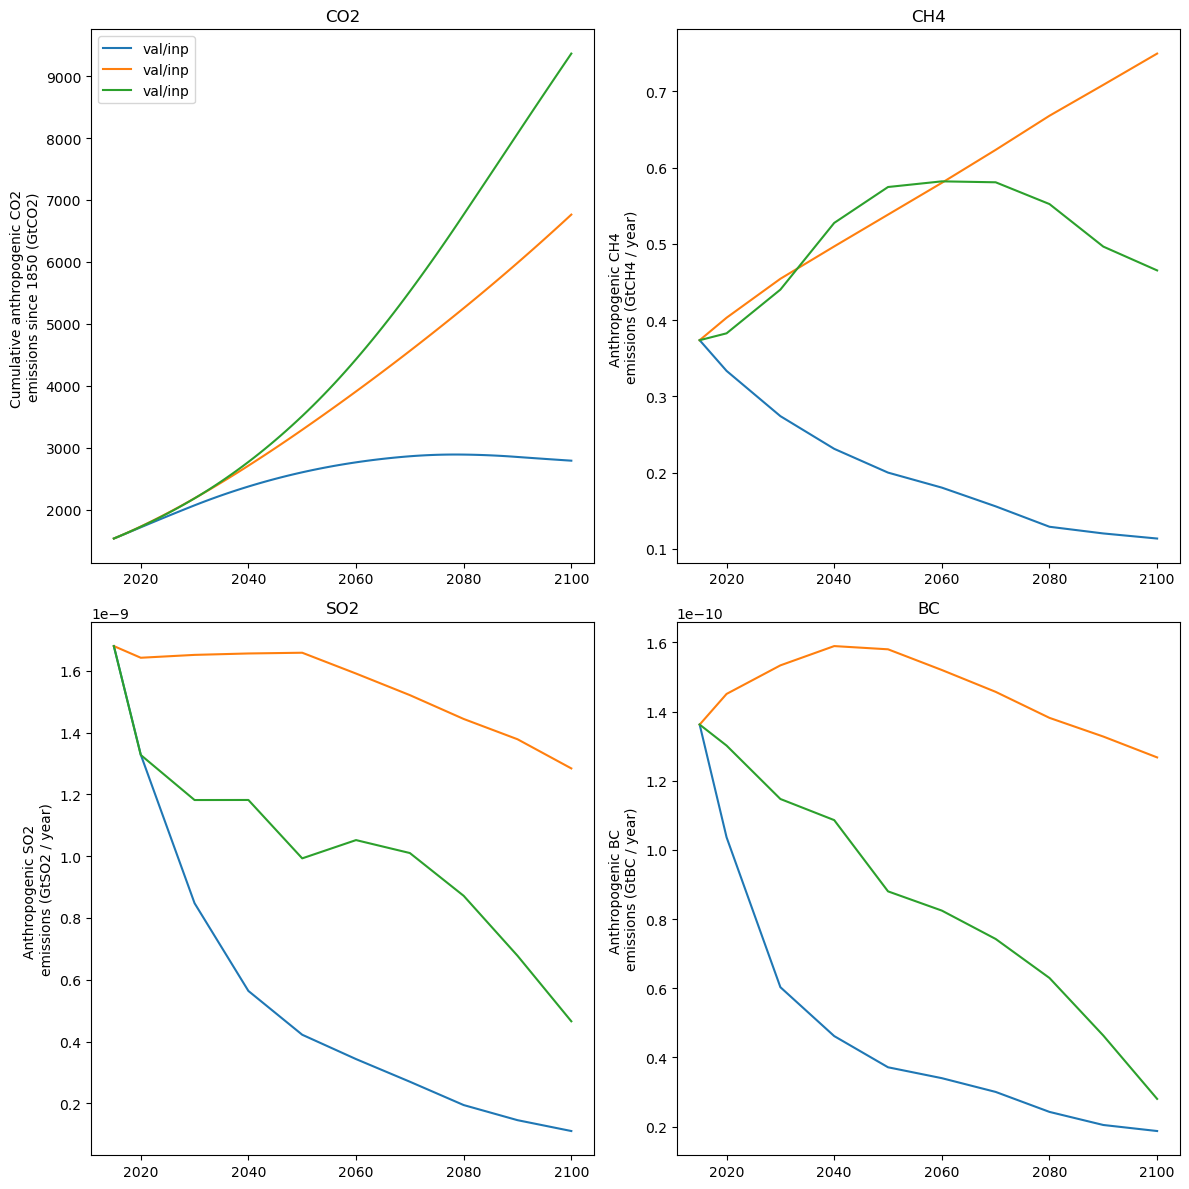

In [40]:
inputs = ["./train_val/inputs_ssp126.nc", "./train_val/inputs_ssp370.nc","./train_val/inputs_ssp585.nc"]
SECONDS_IN_YEAR = 60*60*24*365 

fig, axes = plt.subplots(2, 2, figsize=(12,12))

for input in inputs:
    label=input.split('_')[1][:-3]
    X = xr.open_dataset(input)
    x = range(2015, 2101)

    weights = np.cos(np.deg2rad(X.latitude))
    
    axes[0, 0].plot(x, X['CO2'].data, label=label)
    axes[0, 0].set_ylabel("Cumulative anthropogenic CO2 \nemissions since 1850 (GtCO2)")
    axes[0, 1].plot(x, X['CH4'].data, label=label)
    axes[0, 1].set_ylabel("Anthropogenic CH4 \nemissions (GtCH4 / year)")
    # FIXME: Not sure where this factor of 1000 comes from...! Maybe the CEDS data is really g/m-2/s?
    axes[1, 0].plot(x, X['SO2'].weighted(weights).sum(['latitude', 'longitude']).data*SECONDS_IN_YEAR*1e-9, label=label)
    axes[1, 0].set_ylabel("Anthropogenic SO2 \nemissions (GtSO2 / year)")
    axes[1, 1].plot(x, X['BC'].weighted(weights).sum(['latitude', 'longitude']).data*SECONDS_IN_YEAR*1e-9, label=label)
    axes[1, 1].set_ylabel("Anthropogenic BC \nemissions (GtBC / year)")

axes[0, 0].set_title('CO2')
axes[0, 1].set_title('CH4')
axes[1, 0].set_title('SO2')
axes[1, 1].set_title('BC')
axes[0, 0].legend()
plt.tight_layout()

test_data_path= "./test"+'inputs_ssp245.nc'

### Random Forest Regressor Model Building 

In [41]:
train_files = [ "historical", "ssp585", "ssp126", "ssp370", ]
# Create training and testing arrays
X, solvers = create_predictor_data(train_files)
Y = create_predictdand_data(train_files)



In [42]:
#parameters dictionary
param_dict_tas = {
    'n_estimators': 250,
    'min_samples_split': 5,
    'min_samples_leaf': 7,
    'max_depth': 5
}

param_dict_pr = {
    'n_estimators': 150,
    'min_samples_split': 15,
    'min_samples_leaf': 8,
    'max_depth': 40
}

param_dict_pr90 = {
    'n_estimators': 250,
    'min_samples_split': 15,
    'min_samples_leaf': 12,
    'max_depth': 25
}

param_dict_dtr = {
    'n_estimators': 300,
    'min_samples_split': 10,
    'min_samples_leaf': 12,
    'max_depth': 20
}

In [43]:
rf_tas = rf_model(X, Y['tas'], random_state=0, bootstrap=True, max_features='sqrt', **param_dict_tas)
rf_pr = rf_model(X, Y['pr'], random_state=0, bootstrap=True, max_features='sqrt', **param_dict_pr)
rf_pr90 = rf_model(X, Y['pr90'], random_state=0, bootstrap=True, max_features='sqrt',**param_dict_pr90)
rf_dtr = rf_model(X, Y["diurnal_temperature_range"], random_state=0, bootstrap=True, max_features='sqrt',**param_dict_dtr)

rf_tas.train()
rf_pr.train()
rf_pr90.train()
rf_dtr.train()

In [44]:
## Test on SSP245 pathway 

X_test = get_test_data('ssp245', solvers)
Y_test = create_predictdand_data_test(['ssp245'])

tas_truth = Y_test["tas"]
pr_truth = Y_test["pr"]
pr90_truth = Y_test["pr90"]
dtr_truth = Y_test["diurnal_temperature_range"]


In [45]:
m_out_tas, _ = rf_tas.predict(X_test)
m_out_pr, _ = rf_pr.predict(X_test)
m_out_pr90, _ = rf_pr90.predict(X_test)
m_out_dtr, _ = rf_dtr.predict(X_test)

In [46]:
xr_output = xr.Dataset(dict(tas=m_out_tas, pr=m_out_pr, pr90=m_out_pr90, diurnal_temperature_range=m_out_dtr)).assign_coords(time=m_out_tas.sample + 2014)
#save output to net-cdf file
xr_output.to_netcdf(path_output,'w')

### Testing out predictions with test set

In [47]:
print(f"RMSE: {get_rmse(tas_truth[35:], m_out_tas[35:]).mean()}")
print("\n")

print(f"RMSE: {get_rmse(dtr_truth[35:], m_out_dtr[35:]).mean()}")
print("\n")

print(f"RMSE: {get_rmse(pr_truth[35:], m_out_pr[35:]).mean()}")
print("\n")

print(f"RMSE: {get_rmse(pr90_truth[35:], m_out_pr90[35:]).mean()}")

RMSE: 0.6823172244093356


RMSE: 0.16537489851670092


RMSE: 0.5578336782743653


RMSE: 1.5880423328622344


### Comparing emulated results of RF model to True Results Graphically (Year 2050)

#### True vs Emulated Surface Air Temperature 

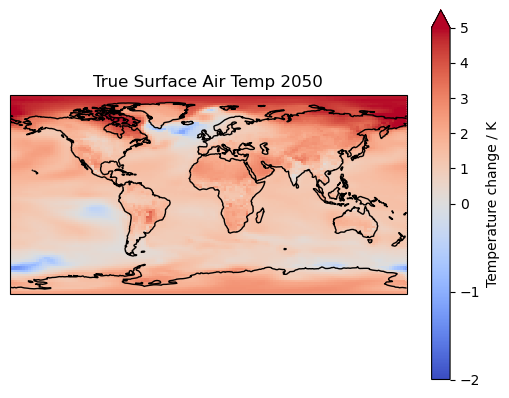

In [48]:
divnorm=colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)

ax = plt.axes(projection=ccrs.PlateCarree())
tas_truth.sel(time=2050).plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
ax.set_title("True Surface Air Temp 2050")
ax.coastlines()
# plt.show()

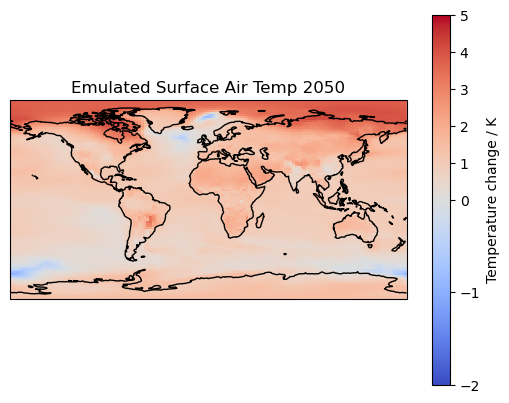

In [49]:
ax = plt.axes(projection=ccrs.PlateCarree())
m_out_tas.sel(sample=35).plot(cmap="coolwarm", norm=divnorm,
                         cbar_kwargs={"label":"Temperature change / K"})
ax.set_title("Emulated Surface Air Temp 2050")
ax.coastlines()
# plt.show()

#### True vs Emulated Diurnal Temperature Range

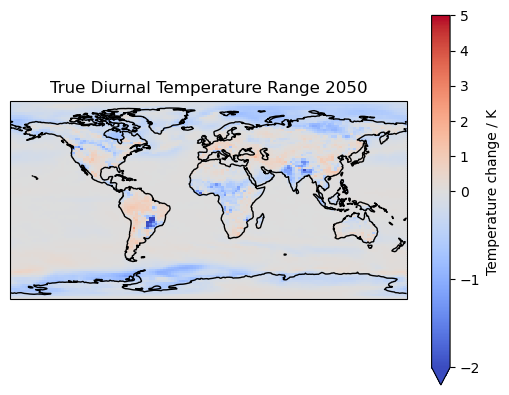

In [50]:
ax = plt.axes(projection=ccrs.PlateCarree())
dtr_truth.sel(time=2050).plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
ax.set_title("True Diurnal Temperature Range 2050")
ax.coastlines()

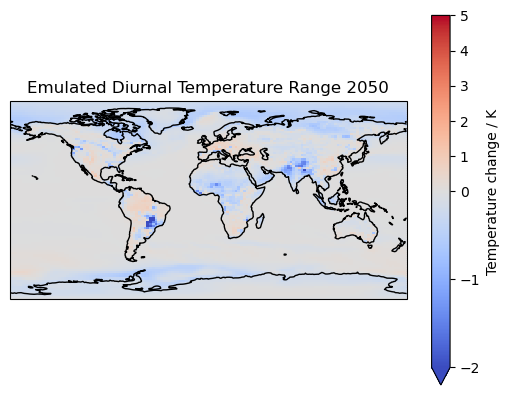

In [51]:
ax = plt.axes(projection=ccrs.PlateCarree())
m_out_dtr.sel(sample=35).plot(cmap="coolwarm", norm=divnorm,
                         cbar_kwargs={"label":"Temperature change / K"})
ax.set_title("Emulated Diurnal Temperature Range 2050")
ax.coastlines()

#### True vs Emulated Percipitation

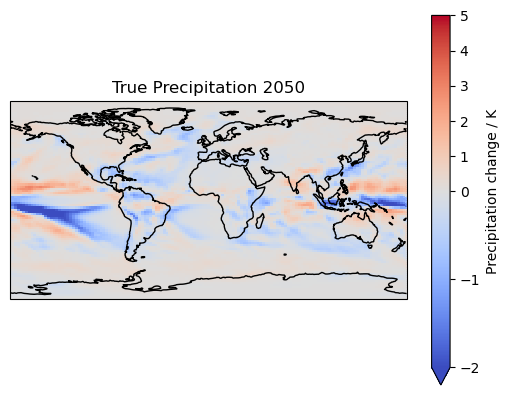

In [52]:
ax = plt.axes(projection=ccrs.PlateCarree())
pr_truth.sel(time=2050).plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Precipitation change / K"})
ax.set_title("True Precipitation 2050")
ax.coastlines()

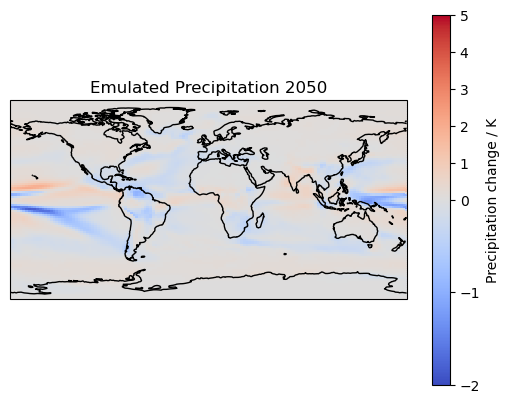

In [53]:
ax = plt.axes(projection=ccrs.PlateCarree())
m_out_pr.sel(sample=35).plot(cmap="coolwarm", norm=divnorm,
                         cbar_kwargs={"label":"Precipitation change / K"})
ax.set_title("Emulated Precipitation 2050")
ax.coastlines()

#### True vs Emulated 90th Percentile Percipitation

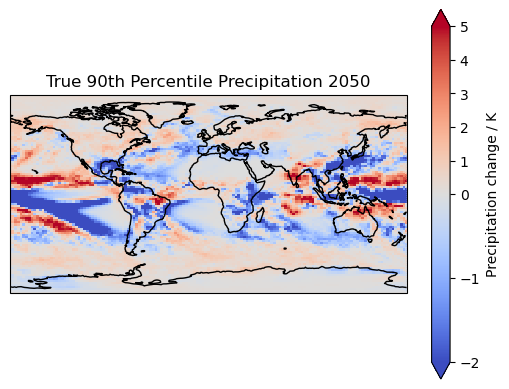

In [54]:

ax = plt.axes(projection=ccrs.PlateCarree())
pr90_truth.sel(time=2050).plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Precipitation change / K"})
ax.set_title("True 90th Percentile Precipitation 2050")
ax.coastlines()

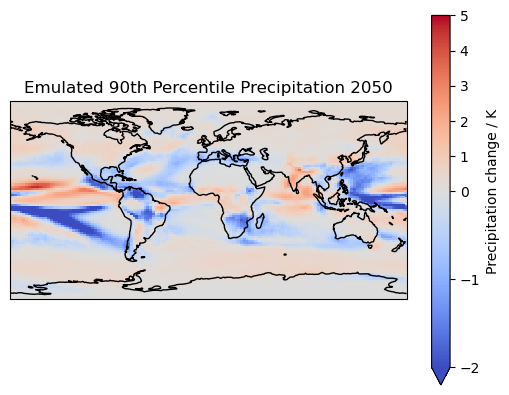

In [55]:
ax = plt.axes(projection=ccrs.PlateCarree())
m_out_pr90.sel(sample=35).plot(cmap="coolwarm", norm=divnorm,
                         cbar_kwargs={"label":"Precipitation change / K"})
ax.set_title("Emulated 90th Percentile Precipitation 2050")
ax.coastlines()

### Running models Again After Grid Search 

In [64]:
X, solvers = create_predictor_data(train_files)
Y = create_predictdand_data(train_files)

In [81]:
# hyperparameter grid 
param_grid = {
    'n_estimators': [200,250,300,350],
    'max_depth': [10, 20,30,40,50],
    'min_samples_split': [10,15,20],
    'min_samples_leaf': [5, 10,15,20]
}

base_model = RandomForestRegressor(random_state=0, bootstrap=True, max_features='log2')

best_params = {}
best_scores = {}

# List of target variables
targets = ['tas', 'diurnal_temperature_range', 'pr', 'pr90']

# Loop over each target variable
for target in targets:
    print(f"Running GridSearchCV for {target}...")
    
    # Get training data
    Y_train = Y[target].mean(dim=["lat", "lon"]).values  
    X_train = X  
    
    # GridSearchCV
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        cv=3,                     
        scoring='neg_root_mean_squared_error',  
        verbose=2,
        n_jobs=-1                
    )
    
    # Fit the model
    grid_search.fit(X_train, Y_train)
    
    # results 
    best_params[target] = grid_search.best_params_
    best_scores[target] = -grid_search.best_score_
    print(f"Best parameters for {target}: {grid_search.best_params_}")
    print(f"Best score for {target} (neg MSE): {grid_search.best_score_}")


results_df = pd.DataFrame({
    'Variable': targets,
    'Best Parameters': [best_params[target] for target in targets],
    'Best Negative MSE': [best_scores[target] for target in targets]
})

print("\nGrid Search Summary:")
print(results_df)


Running GridSearchCV for tas...
Fitting 3 folds for each of 240 candidates, totalling 720 fits
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=250; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=250; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=250; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total 

/glade/u/apps/jupyterhub/jh-23.11/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for tas: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 250}
Best score for tas (neg MSE): -0.9252090045667506
Running GridSearchCV for diurnal_temperature_range...
Fitting 3 folds for each of 240 candidates, totalling 720 fits
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=250; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=250; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=250; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time=   0.3s
[CV] EN

/glade/u/apps/jupyterhub/jh-23.11/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for diurnal_temperature_range: {'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 250}
Best score for diurnal_temperature_range (neg MSE): -0.043179201728882184
Running GridSearchCV for pr...
Fitting 3 folds for each of 240 candidates, totalling 720 fits
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=250; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=250; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=250; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=300; tot

/glade/u/apps/jupyterhub/jh-23.11/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for pr: {'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 250}
Best score for pr (neg MSE): -0.029690789198458956
Running GridSearchCV for pr90...
Fitting 3 folds for each of 240 candidates, totalling 720 fits
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=250; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=250; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=250; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time=   0.3s
[CV] END max_depth=10, min_s

/glade/u/apps/jupyterhub/jh-23.11/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for pr90: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 200}
Best score for pr90 (neg MSE): -0.08041290996747935

Grid Search Summary:
                    Variable  \
0                        tas   
1  diurnal_temperature_range   
2                         pr   
3                       pr90   

                                     Best Parameters  Best Negative MSE  
0  {'max_depth': 10, 'min_samples_leaf': 5, 'min_...           0.925209  
1  {'max_depth': 20, 'min_samples_leaf': 5, 'min_...           0.043179  
2  {'max_depth': 20, 'min_samples_leaf': 5, 'min_...           0.029691  
3  {'max_depth': 10, 'min_samples_leaf': 5, 'min_...           0.080413  


In [67]:
# new parameter values based on grid search  
param_dict_tas_opt = {
    'n_estimators': 250,
    'min_samples_split': 15,
    'min_samples_leaf': 5,
    'max_depth': 10
}

param_dict_pr_opt = {
    'n_estimators': 250,
    'min_samples_split': 15,
    'min_samples_leaf': 5,
    'max_depth': 20
}

param_dict_pr90_opt = {
    'n_estimators': 200,
    'min_samples_split': 15,
    'min_samples_leaf': 5,
    'max_depth': 10
}

param_dict_dtr_opt = {
    'n_estimators': 250,
    'min_samples_split': 10,
    'min_samples_leaf': 5,
    'max_depth': 20
}

In [68]:
# Used log2 instead of sqrt for max_features, training on grid search parameter tuning 

rf_tas = rf_model(X, Y['tas'], random_state=0, bootstrap=True, max_features='log2', **param_dict_tas_opt)
rf_pr = rf_model(X, Y['pr'], random_state=0, bootstrap=True, max_features='log2', **param_dict_pr_opt)
rf_pr90 = rf_model(X, Y['pr90'], random_state=0, bootstrap=True, max_features='log2',**param_dict_pr90_opt)
rf_dtr = rf_model(X, Y["diurnal_temperature_range"], random_state=0, bootstrap=True, max_features='log2',**param_dict_dtr_opt)

rf_tas.train()
rf_pr.train()
rf_pr90.train()
rf_dtr.train()

In [69]:
## Test on SSP245

X_test = get_test_data('ssp245', solvers)
Y_test = create_predictdand_data_test(['ssp245'])

tas_truth = Y_test["tas"]
pr_truth = Y_test["pr"]
pr90_truth = Y_test["pr90"]
dtr_truth = Y_test["diurnal_temperature_range"]


In [70]:
# predictions for each variable 
m_out_tas, _ = rf_tas.predict(X_test)
m_out_pr, _ = rf_pr.predict(X_test)
m_out_pr90, _ = rf_pr90.predict(X_test)
m_out_dtr, _ = rf_dtr.predict(X_test)

In [71]:
path_output = "outputs_ssp245_prediction_hyper_change.nc"
xr_output = xr.Dataset(dict(tas=m_out_tas, pr=m_out_pr, pr90=m_out_pr90, diurnal_temperature_range=m_out_dtr)).assign_coords(time=m_out_tas.sample + 2014)
#save output to net-cdf file 
xr_output.to_netcdf(path_output,'w')

### Testing out predictions with test set

In [72]:
print(f"RMSE: {get_rmse(tas_truth[35:], m_out_tas[35:]).mean()}")
print("\n")

print(f"RMSE: {get_rmse(dtr_truth[35:], m_out_dtr[35:]).mean()}")
print("\n")

print(f"RMSE: {get_rmse(pr_truth[35:], m_out_pr[35:]).mean()}")
print("\n")

print(f"RMSE: {get_rmse(pr90_truth[35:], m_out_pr90[35:]).mean()}")

RMSE: 0.6614993057851092


RMSE: 0.16673128377739266


RMSE: 0.5548657390705033


RMSE: 1.5955868266285376


### Comparing emulated results of New RF model to True Results Graphically (Year 2050)

#### True vs Emulated Surface Air Temperature 

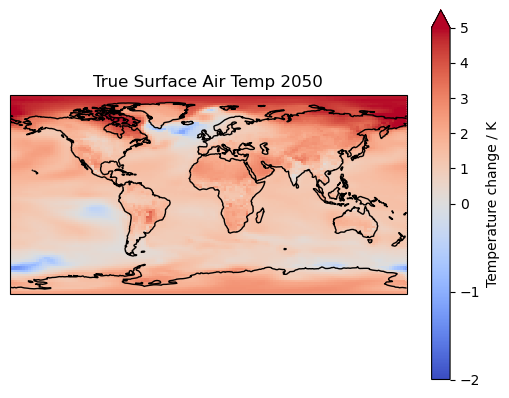

In [73]:
divnorm=colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)

ax = plt.axes(projection=ccrs.PlateCarree())
tas_truth.sel(time=2050).plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
ax.set_title("True Surface Air Temp 2050")
ax.coastlines()
# plt.show()

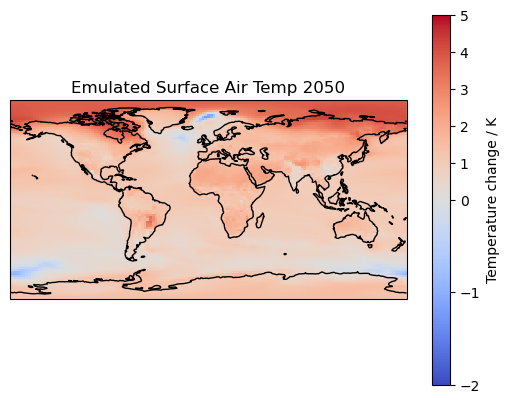

In [74]:
ax = plt.axes(projection=ccrs.PlateCarree())
m_out_tas.sel(sample=35).plot(cmap="coolwarm", norm=divnorm,
                         cbar_kwargs={"label":"Temperature change / K"})
ax.set_title("Emulated Surface Air Temp 2050")
ax.coastlines()
# plt.show()

#### True vs Emulated Diurnal Temperature Range

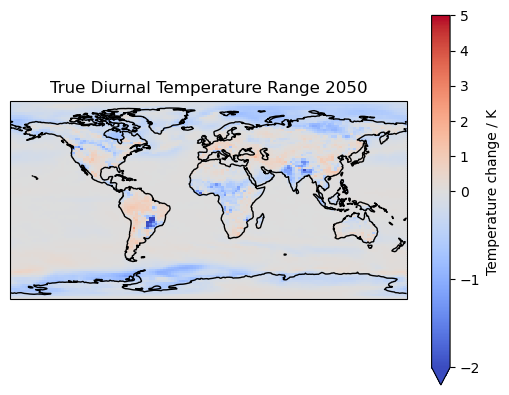

In [75]:
ax = plt.axes(projection=ccrs.PlateCarree())
dtr_truth.sel(time=2050).plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
ax.set_title("True Diurnal Temperature Range 2050")
ax.coastlines()

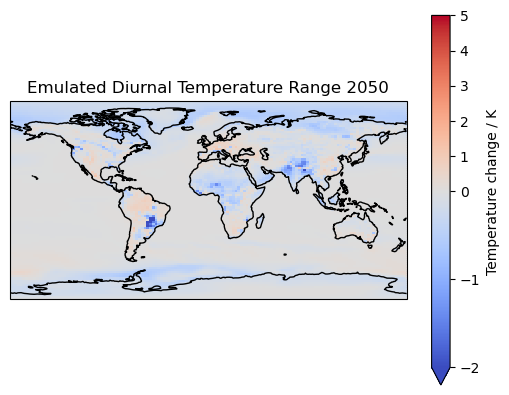

In [76]:
ax = plt.axes(projection=ccrs.PlateCarree())
m_out_dtr.sel(sample=35).plot(cmap="coolwarm", norm=divnorm,
                         cbar_kwargs={"label":"Temperature change / K"})
ax.set_title("Emulated Diurnal Temperature Range 2050")
ax.coastlines()

#### True vs Emulated Precipitation 

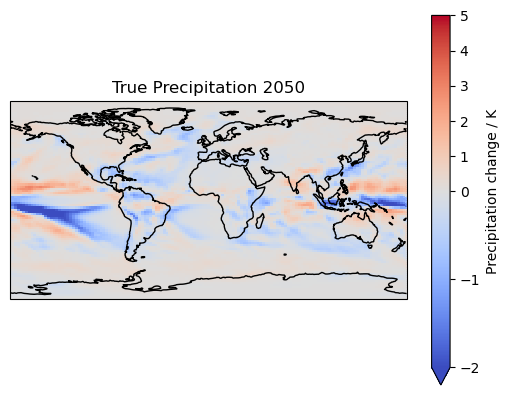

In [77]:
ax = plt.axes(projection=ccrs.PlateCarree())
pr_truth.sel(time=2050).plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Precipitation change / K"})
ax.set_title("True Precipitation 2050")
ax.coastlines()

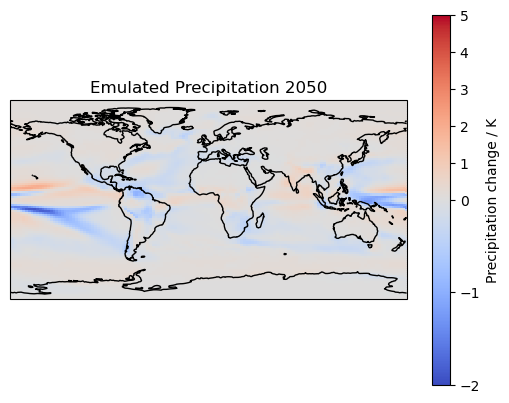

In [78]:
ax = plt.axes(projection=ccrs.PlateCarree())
m_out_pr.sel(sample=35).plot(cmap="coolwarm", norm=divnorm,
                         cbar_kwargs={"label":"Precipitation change / K"})
ax.set_title("Emulated Precipitation 2050")
ax.coastlines()

#### True vs Emulated 90th Percentile Precipitation 

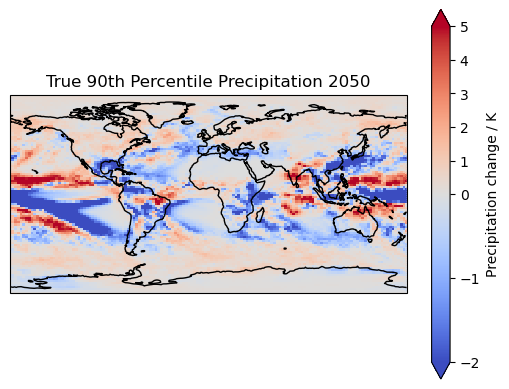

In [79]:
ax = plt.axes(projection=ccrs.PlateCarree())
pr90_truth.sel(time=2050).plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Precipitation change / K"})
ax.set_title("True 90th Percentile Precipitation 2050")
ax.coastlines()

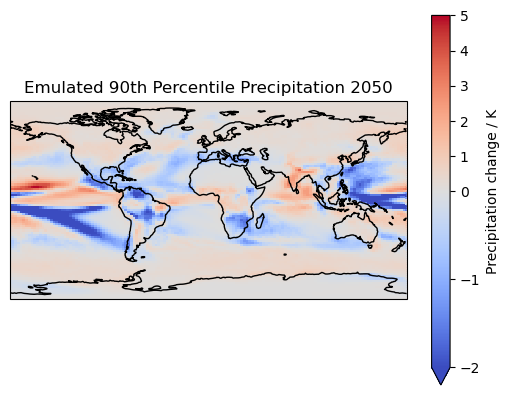

In [80]:
ax = plt.axes(projection=ccrs.PlateCarree())
m_out_pr90.sel(sample=35).plot(cmap="coolwarm", norm=divnorm,
                         cbar_kwargs={"label":"Precipitation change / K"})
ax.set_title("Emulated 90th Percentile Precipitation 2050")
ax.coastlines()